#### Hacettepe University

#### Artificial Intelligence Engineering Department

#### Name - Surname :  Mehmet Alperen Ozcelik

## Classification of Monkey Species using Neural Network

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings('ignore')

def load_images(folderName, size):
    
    imageList = []
    nameList = []
    
    for filename in os.listdir(folderName):
        img = cv2.imread(os.path.join(folderName, filename))
        
        if img is not None:

            resized = cv2.resize(img,size, interpolation= cv2.INTER_LINEAR)
            image = resized.astype('float32')
            image = image / 255
            imageList.append(image)
            nameList.append(filename[1])
    
    return imageList, nameList

def all_images(mainFolder,size):
    
    imageList = []
    specyList = []
    
    for i in range(10):
        
        img, specy = load_images(mainFolder + str(i), size)
        imageList.extend(img)
        specyList.extend(specy)
        
    imageList = np.array(imageList)
    specyList = np.array(specyList)
    
    return imageList, specyList

In [2]:
images,species =  all_images("training/n", (8,8))

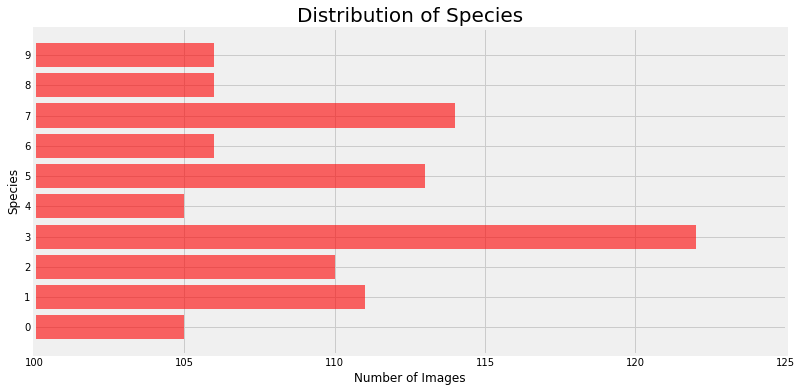

In [3]:
a,b = [],[]
(unique, counts) = np.unique(species, return_counts=True)
frequencies = np.asarray((unique, counts)).T

for i in frequencies:
    a.append(i[0])
    b.append(int(i[1]))
    
fig = plt.figure(figsize=(12, 6))
plt.barh(a, b, color='red',alpha = 0.6)

plt.xlabel("Number of Images")
plt.ylabel("Species")
plt.title("Distribution of Species", size = 20)
plt.xlim([100, 125])
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
X = images.reshape(1098,8*8*3)
y = species

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.10, random_state = 33)

### #Multi Layer Neural Network

In [7]:
from sklearn.base import BaseEstimator

class MultiLayerNN(BaseEstimator):

    def __init__(self, X_train, Y_train, X_val, Y_val, num_of_layers, layer_size):

        self.X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
        self.Y_train = np.squeeze(np.eye(10)[Y_train.astype(np.int).reshape(-1)])
        self.X_val = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis=1)
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(np.int).reshape(-1)])
        self.layer_length = num_of_layers
        self.input_size = layer_size
        self.layer = np.array([self.X_train.shape[1]] + [layer_size] * num_of_layers + [self.Y_train.shape[1]])
        self.weights()

    def weights(self):

        self.weights = []
        for i in range(self.layer.shape[0] - 1):
            self.weights.append(np.random.uniform(-1, 1, size=[self.layer[i], self.layer[i + 1]]))
        self.weights = np.asarray(self.weights)

    def layers(self, batch_size):

        self.h = [np.empty((batch_size, layer)) for layer in self.layer]

    def sigmoid(self, x):

        sgm = 1.0 / (1.0 + np.exp(-x))
        return sgm

    def sigmoid_prime(self, h):

        sgm_pr = h * (1 - h)
        return sgm_pr

    def softmax(self, x):

        softmax = np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)
        return softmax

    def loss_function(self, y_pred, y):

        for i in range(len(y)):
            difference = y[i] - y_pred[i]
            squared_difference = difference ** 2
            summation = summation + squared_difference

        MSE = summation / len(y)
        return MSE

    def forward_propagation(self, b):

        temp = b
        self.h[0] = temp
        for i, weights in enumerate(self.weights):
            temp = self.sigmoid(temp.dot(weights))
            self.h[i + 1] = temp
        self.out = self.softmax(self.h[-1])

    def back_propagation(self, y_batch):

        delta_t = (self.out - y_batch) * self.sigmoid_prime(self.h[-1])
        for i in range(1, len(self.weights) + 1):
            self.weights[-i] -= self.learning_rate * (self.h[-i - 1].T.dot(delta_t)) / self.batch_size
            delta_t = self.sigmoid_prime(self.h[-i - 1]) * (delta_t.dot(self.weights[-i].T))

    def predict(self, X):

        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.layers(X.shape[0])
        self.forward_propagation(X)
        categorical = np.zeros((self.out.shape[0], self.Y_train.shape[1]))
        categorical[np.arange(self.out.shape[0]), self.out.argmax(axis=1)] = 1

        predictions = []

        for i in range(len(categorical)):
            for j in range(10):
                if categorical[i][j] == 1:
                    predictions.append(str(j))

        return predictions

    def train(self, batch_size, epochs, learning_rate):

        self.learning_rate = learning_rate
        self.batch_size = batch_size

        for i in range(epochs):

            self.layers(self.batch_size)
            rand = np.random.permutation(self.X_train.shape[0])

            X_batches = np.array_split(self.X_train[rand], self.X_train.shape[0] / self.batch_size)
            Y_batches = np.array_split(self.Y_train[rand], self.X_train.shape[0] / self.batch_size)

            for x_batch, y_batch in zip(X_batches, Y_batches):
                self.forward_propagation(x_batch)
                self.back_propagation(y_batch)

            self.layers(self.X_val.shape[0])
            self.forward_propagation(self.X_val)

### Change of Layer Numbers

In [8]:
for i in range(1,11):
    model = MultiLayerNN(X_train,y_train,X_test, y_test, num_of_layers = i, layer_size = 128)
    model.train(batch_size=64, epochs=50, learning_rate=0.5)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print("Number of Layers:",i,"Accuracy:",acc)

Number of Layers: 1 Accuracy: 0.33636363636363636
Number of Layers: 2 Accuracy: 0.37272727272727274
Number of Layers: 3 Accuracy: 0.43636363636363634
Number of Layers: 4 Accuracy: 0.41818181818181815
Number of Layers: 5 Accuracy: 0.37272727272727274
Number of Layers: 6 Accuracy: 0.37272727272727274
Number of Layers: 7 Accuracy: 0.11818181818181818
Number of Layers: 8 Accuracy: 0.39090909090909093
Number of Layers: 9 Accuracy: 0.07272727272727272
Number of Layers: 10 Accuracy: 0.13636363636363635


#####  > I decided to use 5 Layers

### Change of Batch Size and Learning Rate

#####  > While my learning rates are between 0.005 and 0.02, since the accuracy is very low, I decided to increase it in these intervals.

In [9]:
for i in range(4,8):
    for j in range(10):
        model = MultiLayerNN(X_train,y_train,X_test, y_test, num_of_layers = 5, layer_size = 128)
        model.train(batch_size=2**i, epochs=50, learning_rate=0.1+(j*0.1))
        pred = model.predict(X_test)
        acc = accuracy_score(y_test, pred)
        print("Batch Size:",2**i,"Learning Rate: %.2f" %(0.1+(j*0.1)),"Accuracy: %.2f" %acc)

Batch Size: 16 Learning Rate: 0.10 Accuracy: 0.25
Batch Size: 16 Learning Rate: 0.20 Accuracy: 0.47
Batch Size: 16 Learning Rate: 0.30 Accuracy: 0.43
Batch Size: 16 Learning Rate: 0.40 Accuracy: 0.46
Batch Size: 16 Learning Rate: 0.50 Accuracy: 0.10
Batch Size: 16 Learning Rate: 0.60 Accuracy: 0.46
Batch Size: 16 Learning Rate: 0.70 Accuracy: 0.35
Batch Size: 16 Learning Rate: 0.80 Accuracy: 0.20
Batch Size: 16 Learning Rate: 0.90 Accuracy: 0.42
Batch Size: 16 Learning Rate: 1.00 Accuracy: 0.35
Batch Size: 32 Learning Rate: 0.10 Accuracy: 0.34
Batch Size: 32 Learning Rate: 0.20 Accuracy: 0.35
Batch Size: 32 Learning Rate: 0.30 Accuracy: 0.39
Batch Size: 32 Learning Rate: 0.40 Accuracy: 0.40
Batch Size: 32 Learning Rate: 0.50 Accuracy: 0.51
Batch Size: 32 Learning Rate: 0.60 Accuracy: 0.50
Batch Size: 32 Learning Rate: 0.70 Accuracy: 0.30
Batch Size: 32 Learning Rate: 0.80 Accuracy: 0.50
Batch Size: 32 Learning Rate: 0.90 Accuracy: 0.41
Batch Size: 32 Learning Rate: 1.00 Accuracy: 0.45


##### As a result, I decided that the best batch size is 32 and the best learning rate is 0.5 in my Multi Layer Neural Network

### #Convolutional Neural Network

In [10]:
images,species =  all_images("training/n", (32,32))

In [11]:
X = images
y = species.reshape(len(y), 1)
y = tf.keras.utils.to_categorical(y, num_classes=10, dtype="int")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state = 33)

##### As a result of my experiments in the code, I decided to use 32 as the number of units and (3,3) as the width and height value. I can't show these attempts because they all take about 2 hours to run :(

### Single Convolutional Layer

In [12]:
def CNN(activation_func, learning_rate, number_of_units = 32, width_and_height = (3,3)):

    model = Sequential()
    model.add(Conv2D(number_of_units, width_and_height, activation = activation_func, kernel_initializer = 'he_uniform', padding= 'same', input_shape=(32, 32, 3)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr = learning_rate, momentum=0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

#### Change of Batch Size and Learning Rate

In [14]:
for i in range(4,8):
    for j in range(5):
        model = CNN('relu', (0.01 + 0.005*j)) 
        fit = model.fit(X_train, y_train, epochs=30, batch_size=2**i, verbose=0)
        _, acc = model.evaluate(X_test, y_test, verbose = 0)
        print("Batch Size:",2**i,"Learning Rate: %.2f" %(0.05+(j*0.1)),"Accuracy: %.2f" %acc)

Batch Size: 16 Learning Rate: 0.05 Accuracy: 0.58
Batch Size: 16 Learning Rate: 0.15 Accuracy: 0.52
Batch Size: 16 Learning Rate: 0.25 Accuracy: 0.54
Batch Size: 16 Learning Rate: 0.35 Accuracy: 0.50
Batch Size: 16 Learning Rate: 0.45 Accuracy: 0.50
Batch Size: 32 Learning Rate: 0.05 Accuracy: 0.61
Batch Size: 32 Learning Rate: 0.15 Accuracy: 0.60
Batch Size: 32 Learning Rate: 0.25 Accuracy: 0.56
Batch Size: 32 Learning Rate: 0.35 Accuracy: 0.57
Batch Size: 32 Learning Rate: 0.45 Accuracy: 0.55
Batch Size: 64 Learning Rate: 0.05 Accuracy: 0.55
Batch Size: 64 Learning Rate: 0.15 Accuracy: 0.59
Batch Size: 64 Learning Rate: 0.25 Accuracy: 0.56
Batch Size: 64 Learning Rate: 0.35 Accuracy: 0.56
Batch Size: 64 Learning Rate: 0.45 Accuracy: 0.45
Batch Size: 128 Learning Rate: 0.05 Accuracy: 0.55
Batch Size: 128 Learning Rate: 0.15 Accuracy: 0.56
Batch Size: 128 Learning Rate: 0.25 Accuracy: 0.59
Batch Size: 128 Learning Rate: 0.35 Accuracy: 0.55
Batch Size: 128 Learning Rate: 0.45 Accuracy: 

##### As a result, I decided that the best batch size is 32 and the best learning rate is 0.05 in Single Convolutional Layer CNN model

#### Change of Activation Function

In [15]:
for i in range(2):
    if i == 1:
        x = 'relu'
    else:
        x = 'sigmoid'
    model = CNN(x, (0.01)) 
    fit = model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)
    _, acc = model.evaluate(X_test, y_test, verbose = 0)
    print("Activation Function:",x, "Accuracy: %.2f" %acc)

Activation Function: sigmoid Accuracy: 0.31
Activation Function: relu Accuracy: 0.59


##### I decided to use ReLu function as an activation function in Single Convolutional Layer CNN model

### Two Convolutional Layers and Two Fully Connected Layers

In [16]:
def CNN2(activation_func, learning_rate, number_of_units = 32, width_and_height = (3,3)):

    model = Sequential()
    model.add(Conv2D(number_of_units, width_and_height, activation = activation_func, kernel_initializer = 'he_uniform', padding= 'same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(number_of_units, width_and_height, activation = activation_func, kernel_initializer = 'he_uniform', padding= 'same'))
    model.add(MaxPooling2D(1,1))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr = learning_rate, momentum=0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

#### Change of Batch Size and Learning Rate

In [17]:
for i in range(4,8):
    for j in range(5):
        model = CNN2('relu', (0.01 + 0.005*j)) 
        fit = model.fit(X_train, y_train, epochs=30, batch_size=2**i, verbose=0)
        _, acc = model.evaluate(X_test, y_test, verbose = 0)
        print("Batch Size:",2**i,"Learning Rate: %.2f" %(0.05+(j*0.1)),"Accuracy: %.2f" %acc)   

Batch Size: 16 Learning Rate: 0.05 Accuracy: 0.59
Batch Size: 16 Learning Rate: 0.15 Accuracy: 0.57
Batch Size: 16 Learning Rate: 0.25 Accuracy: 0.49
Batch Size: 16 Learning Rate: 0.35 Accuracy: 0.40
Batch Size: 16 Learning Rate: 0.45 Accuracy: 0.37
Batch Size: 32 Learning Rate: 0.05 Accuracy: 0.60
Batch Size: 32 Learning Rate: 0.15 Accuracy: 0.58
Batch Size: 32 Learning Rate: 0.25 Accuracy: 0.59
Batch Size: 32 Learning Rate: 0.35 Accuracy: 0.57
Batch Size: 32 Learning Rate: 0.45 Accuracy: 0.53
Batch Size: 64 Learning Rate: 0.05 Accuracy: 0.64
Batch Size: 64 Learning Rate: 0.15 Accuracy: 0.61
Batch Size: 64 Learning Rate: 0.25 Accuracy: 0.58
Batch Size: 64 Learning Rate: 0.35 Accuracy: 0.57
Batch Size: 64 Learning Rate: 0.45 Accuracy: 0.58
Batch Size: 128 Learning Rate: 0.05 Accuracy: 0.59
Batch Size: 128 Learning Rate: 0.15 Accuracy: 0.61
Batch Size: 128 Learning Rate: 0.25 Accuracy: 0.59
Batch Size: 128 Learning Rate: 0.35 Accuracy: 0.58
Batch Size: 128 Learning Rate: 0.45 Accuracy: 

##### As a result, I decided that the best batch size is 64 and the best learning rate is 0.05 in Two Convolutional Layers and Two Fully Connected Layers CNN model

#### Change of Activation Function

In [19]:
for i in range(2):
    if i == 1:
        x = 'relu'
    else:
        x = 'sigmoid'
    model = CNN2(x, 0.05) 
    fit = model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)
    _, acc = model.evaluate(X_test, y_test, verbose = 0)
    print("Activation Function:",x, "Accuracy: %.2f" %acc)

Activation Function: sigmoid Accuracy: 0.30
Activation Function: relu Accuracy: 0.50


##### I decided to use ReLu function as an activation function in  Two Convolutional Layers and Two Fully Connected Layers CNN model

### CONCLUSION:


###### Factors such as learning rate, batch size, number of layers change the model a lot, but I was surprised that the accuracy values that appear as we run the model again are extremely different, perhaps I may not have been able to use the right models for this data.

###### At the same time, although it seems that there are 6-7 parameters, it takes a very long time and patience to find the most optimal value of the combination of all of them.